In [4]:
import os
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties

# 獲取當前工作目錄
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
version3_path = os.path.join(parent_dir, "Version3")

# 暫時將工作目錄切換到 Version3
os.chdir(version3_path)

from sklearn.cluster import AgglomerativeClustering
from tdamapper.core_old import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.clustering import FailSafeClustering

from utils.models import *
from utils.utils_v3 import *
from utils.plots import *

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

dataA2 = pd.read_csv("./Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("./Data/A1.csv")

[Errno 2] No such file or directory: 'C:\\System\\Library\\Fonts\\PingFang.ttc'


In [6]:

select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
    
    # 篩選駕駛人的資料
    '道路型態子類別名稱'
]
# select_lst = dataA1.columns

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    main_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = main_data[main_data['發生月份'] < 11]
    selected_data = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    split_death_injury_data = split_death_injury(selected_data['死亡受傷人數'])
    full_data = pd.concat([selected_data, split_death_injury_data], axis=1)

    # 補齊缺失值
    full_data[select_lst] = full_data[select_lst].fillna('未紀錄')

    # 速限範圍
    full_data = full_data[(full_data['速限-第1當事者'] < 200) &
                      (full_data['當事者事故發生時年齡'] < 100) &
                      (full_data['當事者事故發生時年齡'] > 0)]

    full_data.drop(columns=['死亡受傷人數'], inplace=True)
    
    # 篩選汽車的資料
    full_data = full_data[full_data['車輛撞擊部位大類別名稱-最初'] == '機車與自行車']
    # 篩選離群資料(影響MCA的因子得分)
    full_data = full_data[(full_data['肇因研判大類別名稱-主要'] != '非駕駛者') &
                  (full_data['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)') &
                  (full_data['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)') &
                  (full_data['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄') &
                    (full_data['車輛撞擊部位大類別名稱-最初'] != '未紀錄')&
                    (full_data['道路型態大類別名稱'] != '平交道') &
                    (full_data['道路型態子類別名稱'] != '廣場') &
                    (full_data['道路型態子類別名稱'] != '其他') &
                    (full_data['道路型態子類別名稱'] != '圓環廣場')]
    
    full_data.drop(columns=['車輛撞擊部位大類別名稱-最初'], inplace=True)
    
    return full_data

full_dataA1 = preprocess(dataA1, select_lst)
full_dataA2 = preprocess(dataA2, select_lst)

# full_dataA2['道路型態子類別名稱'].value_counts()

In [11]:
# 下採樣資料
sampling_ratio = 0.25  # 下採樣比例，根據A1 和 A2 原始數據量比例調整
total_ratio = len(full_dataA1) / len(full_dataA2) # 保留 A1/A2 的比例
downsampled_A1, downsampled_A2 = downsample_by_month_simple(full_dataA1, full_dataA2, sampling_ratio, total_ratio)

# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)
# 處理年齡和速限
rbind_data = process_age_speed(rbind_data)
rbind_data.drop(['死亡', '受傷'], axis=1, inplace=True)
# 唯一值處理
columns_to_drop = []
for column in rbind_data.columns:
    if rbind_data[column].nunique() == 1:  # 檢查唯一值數量是否等於 1
        columns_to_drop.append(column)
rbind_data.drop(columns=columns_to_drop, inplace=True)
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)
print('dummy_data:', dummy_data.shape)
mapper_numpy = dummy_data.to_numpy()

# rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']

16 4003
16 4003
17 4254
15 3753
13 3253
15 3753
21 5255
19 4754
14 3503
16 4003
dummy_data: (40696, 140)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

# Kmode

In [ ]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)

cost = []
all_results = {}
K = range(1, 5)

for k in K:

    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=10
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

In [ ]:
# with open('Version3/Data/MotorData/kmode_result.pickle', 'wb') as f:
#     pickle.dump(all_results, f)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [155]:
print(pd.Series(all_results[2]['labels']).value_counts())
rbind_data['Cluster'] = all_results[2]['labels']

1    48690
0    46813
Name: count, dtype: int64


# MCA

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.140         3.65%                      3.65%
1              0.090         2.34%                      5.99%
2              0.075         1.95%                      7.94%
3              0.069         1.81%                      9.75%
4              0.068         1.78%                     11.54%
5              0.065         1.70%                     13.24%
6              0.063         1.65%                     14.89%
7              0.060         1.56%                     16.45%
8              0.055         1.44%                     17.89%


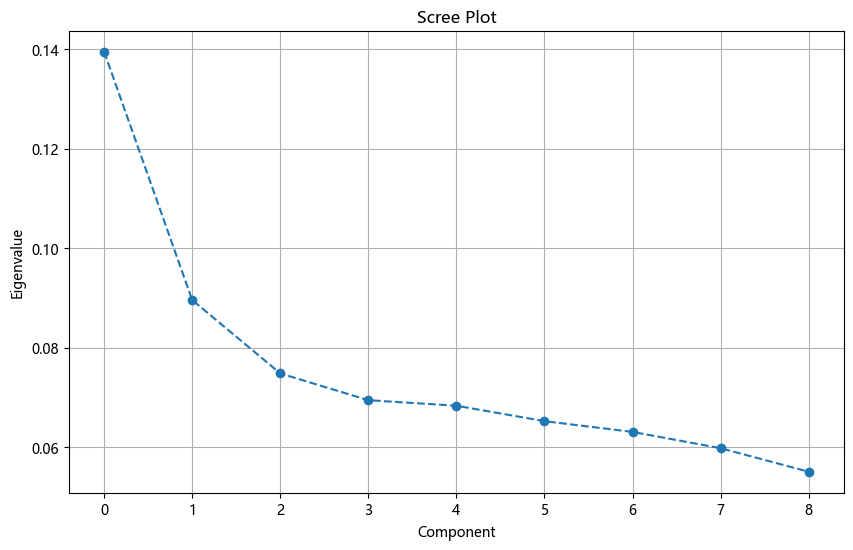

In [12]:
mca = prince.MCA(
    one_hot=False,
    n_components=9,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
    # random_state=43
)

mca.fit(dummy_data)
lens = mca.transform(dummy_data)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [13]:
# grid_search_info = {
#     'lens': lens,
#     'mapper_numpy': mapper_numpy,
# }
# with open('../ForMatrix/CalculatedData/motor.pkl', 'wb') as f:
#     pickle.dump(grid_search_info, f)

In [ ]:
col_coordinate = mca.column_coordinates(dummy_data)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))
plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [ ]:
Overlap = [1, 3, 5]
Interval = [2]

detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=1
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"../Version4/Gridsearch/Component9Motor/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

detailed_results_df = pd.DataFrame(detailed_results)

In [3]:
with open('../Version4/GridSearch/Component9Motor/results_o2i11_new.pkl', 'rb') as f:
    detailed_results_df = pickle.load(f)

# 目前分析使用的模型

In [ ]:
choose = '死亡'

for i in [14]:
    print(f'Seed: {i}')
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=150,
                                   range_lst=[-0.05, 0.075, 0.2, -0.2], dim=3)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, sum_of_data, avg=True)
    full_info = mapper_plotter.extract_data()
    full_info[['x', 'y', 'z']] = rotate_z(full_info[['x', 'y', 'z']], -30)
    mapper_plotter.map_colors(choose, size=15, threshold=0)
    mapper_plotter.plot_dens(choose, avg=True, set_label=False, size=3000, minimum_lst=[0, 0.025])
    # mapper_plotter.plot_3d_pvis(range_lst=[-0.2, 0.2, 0.2, -0.2])

In [ ]:
# lst = ['Cluster', '車輛撞擊部位大類別名稱-最初', '當事者事故發生時年齡', '顯著特徵']
lst = ['天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
       '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-主要', '道路型態子類別名稱']

for choose in lst:
    try:
        print(f'Seed: {i}')
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=8, iterations=150,
                                    range_lst=[-0.1, 0.1, 0.2, -0.2], dim=2)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        # full_info[['x', 'y', 'z']] = rotate_z(full_info[['x', 'y', 'z']], 70)
        mapper_plotter.map_colors(choose, size=15, threshold=0)
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                            save_path=f"../Version4/GridSearch/MapperColor/Motor/o2_i9_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
Overlap = [1, 3, 5]
Interval = [2, 6, 10]
choose = '天候名稱'

for o in Overlap:
    for i in Interval:
        with open(f'../Version4/GridSearch/Component8Motor/results_o{o}i{i}.pkl', 'rb') as f:
            detailed_results_df = pickle.load(f)
            print(detailed_results_df['mapper_info'])

        try:
            print(f'Seed: {i}')
            mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=8, iterations=150, dim=2)
            mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
            full_info = mapper_plotter.extract_data()
            # full_info[['x', 'y', 'z']] = rotate_z(full_info[['x', 'y', 'z']], 70)
            mapper_plotter.map_colors(choose, size=15, threshold=0)
            mapper_plotter.plot(choose, avg=False, set_label=True, size=100,
                                save_path=f"../Version4/GridSearch/Mapper/Motor/o{o}_i{i}_{choose}.png")
        except Exception as e:
            print(e)
            continue

# Polygon

In [ ]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(-0.1, -0.03), (-0.1, 0),(-0.07, 0.1), (0, 0.06), (0.02, 0.04), (-0.06, 0.01)])
rectangle2 = Polygon([(-0.04, -0.02), (-0.06, 0.01), (0.02, 0.04), (0.02, 0.02)])
rectangle3 = Polygon([(-0.04, -0.03), (-0.04, -0.02),(0.02, 0.02), (0.05, 0.05), (0.15, 0), (0.07, -0.02)])
rectangle4 = Polygon([(-0.065, -0.1), (-0.04, -0.03), (0.07, -0.02), (0.1, -0.1)])

filtered_full_info = full_info[(full_info['y'] > -0.2) &
                               (full_info['y'] < 0.1) &
                               (full_info['x'] > -0.1) &
                               (full_info['x'] < 0.15)]
filtered_full_info = filtered_full_info[filtered_full_info['size'] > 15]
# filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]
label_3 = filtered_full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3, rectangle4], 
                              ['green', 'blue', 'purple', 'orange'], 
                              [0.2, 0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [23]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_3", "full_out"],
    [count_0, count_1, count_2, count_3, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 找出群體2和3的交集
intersection_21 = {idx for idx in count_2 if idx in count_1}

# 從交集中移除屬於群體2和3交集的資料
intersection_indexes -= intersection_21

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes and i not in intersection_21]
count_1 = [i for i in count_1 if i not in intersection_indexes and i not in intersection_21]
count_2 = [i for i in count_2 if i not in intersection_indexes and i not in intersection_21]
count_3 = [i for i in count_3 if i not in intersection_indexes and i not in intersection_21]
count_out = [i for i in count_out if i not in intersection_indexes and i not in intersection_21]

# 分群處理
full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]
full_21 = dummy_data.loc[list(intersection_21)]
overlap_data = dummy_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]
assert len(intersection_21) == full_21.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + full_21.shape[0] + overlap_data.shape[0])
print(dummy_data.shape[0])


87488
95503


In [154]:
full_info.to_csv('./Data/MotorData/full_info.csv', index=False)
full_0.to_csv('./Data/MotorData/full_0.csv', index=False)
full_1.to_csv('./Data/MotorData/full_1.csv', index=False)
full_2.to_csv('./Data/MotorData/full_2.csv', index=False)
full_3.to_csv('./Data/MotorData/full_3.csv', index=False)
full_out.to_csv('./Data/MotorData/full_out.csv', index=False)
overlap_data.to_csv('./Data/MotorData/overlap_data.csv', index=False)
full_21.to_csv('./Data/MotorData/full_21.csv', index=False)

In [ ]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(full_21['死亡'].value_counts())
print(dummy_data['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())